# Práctica 1 - Computación paralela y distribuida
### Implementación del efecto borroso de  una imagen
- Edder Hernández Forero
- Julián David Rodríguez Ruiz
- Alberto Nicolai Romero Martínez





In [4]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
from IPython.display import display, Image, HTML, display_html

Populating the interactive namespace from numpy and matplotlib


In [12]:
!lscpu
!ls

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              8
On-line CPU(s) list: 0-7
Thread(s) per core:  2
Core(s) per socket:  4
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               60
Model name:          Intel(R) Core(TM) i7-4790 CPU @ 3.60GHz
Stepping:            3
CPU MHz:             2989.476
CPU max MHz:         4000.0000
CPU min MHz:         800.0000
BogoMIPS:            7183.44
Virtualization:      VT-x
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            8192K
NUMA node0 CPU(s):   0-7
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor ds_cpl vmx smx est tm2 ssse3 sdbg f

# Elección del algoritmo

In [13]:
#Primer algoritmo O(W*H*K²)

#Por cada pixel se hace un promedio de toda la región del kernel.
#Con 8 hilos
!gcc blur-effect.c -o blur -lm -pthread

t_out = !/usr/bin/time -f "%e" ./blur 4k.jpg ./out/4k_blur.jpg 21 8
print(t_out)

#Segundo algoritmo O(W*H*2K)

#Se ejecuta primero un blur horizontal y luego uno vertical encima de ese.
#Por cada pixel se hace un promedio de todo el rango de una dimensión del kernel.
#Secuencial

!gcc blur-effect-fast.c -o blur-fast -lm

t_out = !/usr/bin/time -f "%e" ./blur-fast 4k.jpg ./out/4k_blur.jpg 21 1
print(t_out)

['7.32']
['3.08']


# Ejecución de las pruebas

In [14]:
!gcc blur-effect.c -o blur -lm -pthread



image_names = ['720', '1080', '4k']
images = []
dfs = {}
iterations = 1



for image in image_names:
    print("Image name: ", image)
    times = pd.DataFrame()
    for threads in range(5):
        for kernel in range(7):        
            t = []
            print("\tThreads: ", 2**threads, "; Kernel size: ",3 + 2*kernel)
            for _ in range(iterations):
                t_out = !/usr/bin/time -f "%e" ./blur {image}.jpg ./out/{image}_blur.jpg {3 + 2*kernel} {2**threads}
                t.append(float(t_out[0]))            
            times = times.append(pd.Series(t, dtype = "float64"), ignore_index = True)
    print(times)
    dfs[image] = times
    dfs[image].to_csv( image + "_time.csv" )
    images.append(Image((image + '_blur.jpg'), width = 500))

    

            
            
display(*images)

Image name:  720
	Threads:  1 ; Kernel size:  3
	Threads:  1 ; Kernel size:  5
	Threads:  1 ; Kernel size:  7
	Threads:  1 ; Kernel size:  9
	Threads:  1 ; Kernel size:  11
	Threads:  1 ; Kernel size:  13
	Threads:  1 ; Kernel size:  15
	Threads:  2 ; Kernel size:  3
	Threads:  2 ; Kernel size:  5
	Threads:  2 ; Kernel size:  7
	Threads:  2 ; Kernel size:  9
	Threads:  2 ; Kernel size:  11
	Threads:  2 ; Kernel size:  13
	Threads:  2 ; Kernel size:  15
	Threads:  4 ; Kernel size:  3
	Threads:  4 ; Kernel size:  5
	Threads:  4 ; Kernel size:  7
	Threads:  4 ; Kernel size:  9
	Threads:  4 ; Kernel size:  11
	Threads:  4 ; Kernel size:  13
	Threads:  4 ; Kernel size:  15
	Threads:  8 ; Kernel size:  3
	Threads:  8 ; Kernel size:  5
	Threads:  8 ; Kernel size:  7
	Threads:  8 ; Kernel size:  9
	Threads:  8 ; Kernel size:  11
	Threads:  8 ; Kernel size:  13
	Threads:  8 ; Kernel size:  15
	Threads:  16 ; Kernel size:  3
	Threads:  16 ; Kernel size:  5
	Threads:  16 ; Kernel size:  7
	Thread

FileNotFoundError: No such file or directory: '720_blur.jpg'

FileNotFoundError: No such file or directory: '720_blur.jpg'

<IPython.core.display.Image object>

FileNotFoundError: No such file or directory: '1080_blur.jpg'

FileNotFoundError: No such file or directory: '1080_blur.jpg'

<IPython.core.display.Image object>

FileNotFoundError: No such file or directory: '4k_blur.jpg'

FileNotFoundError: No such file or directory: '4k_blur.jpg'

<IPython.core.display.Image object>

# Gráficas de tiempo de respuesta y speedup

In [9]:
def plot_results(image_name):
    # 1 import sys
    # config matplotlib
    matplotlib.rcParams['figure.figsize'] = [20, 10]  # for square canvas
    matplotlib.rcParams['figure.subplot.left'] = 0
    matplotlib.rcParams['figure.subplot.bottom'] = 0
    matplotlib.rcParams['figure.subplot.right'] = 1
    matplotlib.rcParams['figure.subplot.top'] = 1

    # 2 arg = str(sys.argv)
    def auto_label(point, ax):
        # """Attach a text label above each bar in *rects*, displaying its height."""
        # https://matplotlib.org/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
        print(type(point))
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    #
    # sec, 2, 4, 8, 16
    # =======================================================================
    #                               DATA
    # ========================================================================
    """
    df_example = pd.DataFrame(np.random.rand(7 * 5, 10))
    df_example.to_csv("example.csv")"""

    size_group = 7
    num_of_group = 5
    decimals = 2
    # 3 cereal_df = pd.read_csv("arg[1]")
    cereal_df = pd.read_csv("{}_time.csv".format(image_name))

    print("Image name: {}".format(image_name))
    num = cereal_df.to_numpy()
    avg = []
    deviation = []
    kernelLabel = ["K=3", "K=5", "k=7", "K=9", "K=11", "k=13", "K=15"]
    threadsLabel = ["th=1", "th=2", "th=4", "th=8", "th=16"]

    # obtain central tendency measures
    for val in num:
        avg.append(np.mean(val[1:]))
        deviation.append((np.std(val[1:])))

    data = []
    speedup = []
    # tabular
    for i in range(num_of_group):
        data.append(np.around(avg[i * size_group:(i * size_group) + size_group], decimals=decimals))
        speedup.append((np.around(np.divide(data[0], data[i]), decimals=decimals)))
    data = np.array(data)
    speedup = np.array(speedup)

    df1 = pd.DataFrame(data, index=threadsLabel,
                       columns=kernelLabel)
    df2 = pd.DataFrame(speedup, index=threadsLabel,
                       columns=kernelLabel)
    # =======================================================================
    #                            Graphs
    # =======================================================================

    x = np.arange(len(kernelLabel))
    x1 = np.arange(len(threadsLabel))
    width = 0.15

    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()

    # Graphs labels
    ax1.set_ylabel("Tiempo (s)")
    ax1.set_xlabel("Hilos")
    ax1.set_title("Tiempo de respuesta")
    ax1.set_xticks(x)
    ax1.set_xticklabels(threadsLabel)

    ax2.set_ylabel("Speedup")
    ax2.set_xlabel("Hilos")
    ax2.set_title("Speedup por hilos")
    ax2.set_xticks(x1)
    ax2.set_xticklabels(threadsLabel)

    rects = []
    line = []

    colors = ['#ffc100', '#ff9a00', '#ff7400', '#ff4d00', '#ff0000']
    # bars
    for i in range(size_group):
        # r = ax1.bar(x + ((i - (size_group / 4)) * width), data[i], width, label=threadsLabel[i], color=colors[i])
        ax1.plot(data[:, i], marker='o', label=kernelLabel[i], linewidth=2.0)

    for i in range(size_group):
        ax2.plot(speedup[:, i], marker='o', label=kernelLabel[i], linewidth=2.0)

    ax1.legend()
    ax2.legend()
    fig1.tight_layout()
    fig2.tight_layout()

    display(HTML('<h2>Tiempo de respuesta</h2>'))
    display_html(df1)
    display(HTML('<h2>Speedup</h2>'))
    display_html(df2)
    plt.show()


Image name: 720


,K=3,K=5,k=7,K=9,K=11,k=13,K=15
th=1,0.14,0.26,0.42,0.63,0.89,1.20,1.53
th=2,0.10,0.16,0.24,0.34,0.47,0.62,0.79
th=4,0.09,0.13,0.16,0.23,0.29,0.36,0.46
th=8,0.07,0.10,0.14,0.19,0.25,0.33,0.44
th=16,0.07,0.10,0.14,0.20,0.29,0.34,0.44


,K=3,K=5,k=7,K=9,K=11,k=13,K=15
th=1,1.00,1.00,1.00,1.00,1.00,1.00,1.00
th=2,1.40,1.62,1.75,1.85,1.89,1.94,1.94
th=4,1.56,2.00,2.62,2.74,3.07,3.33,3.33
th=8,2.00,2.60,3.00,3.32,3.56,3.64,3.48
th=16,2.00,2.60,3.00,3.15,3.07,3.53,3.48


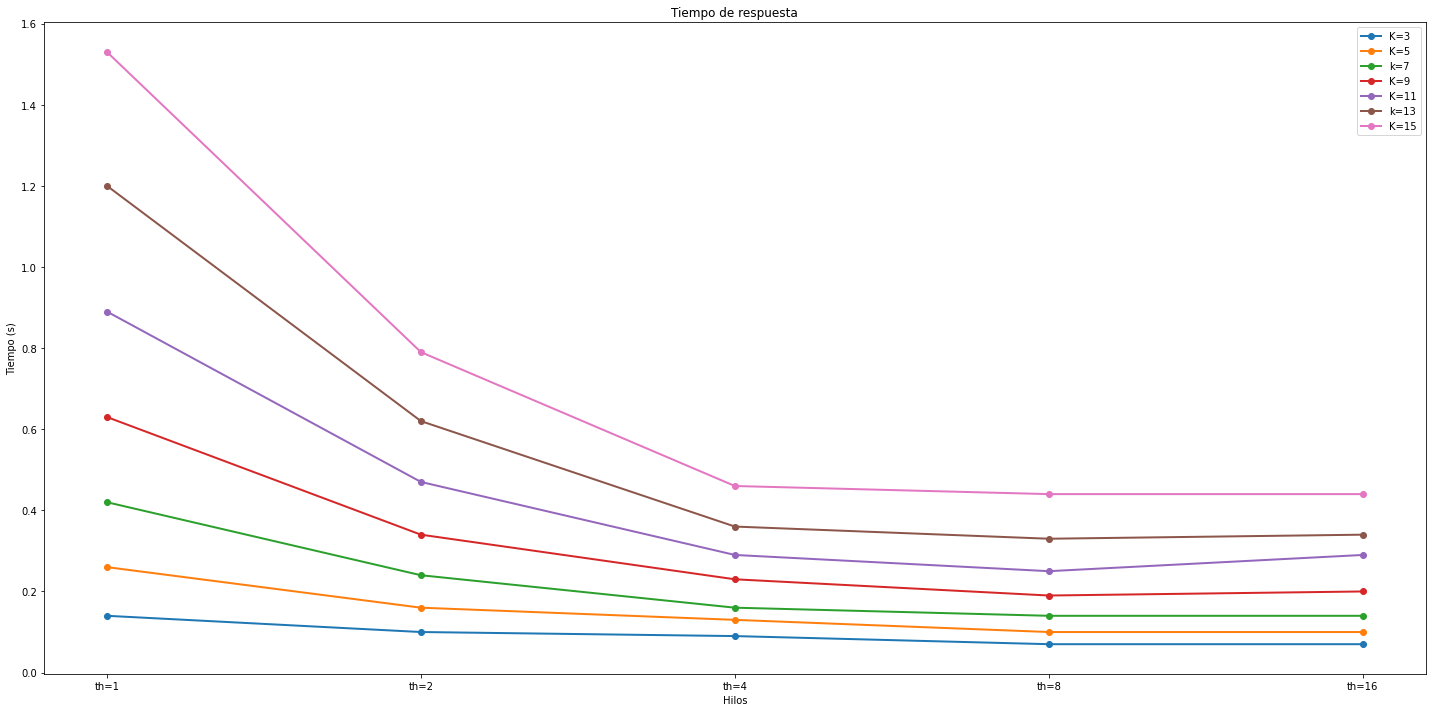

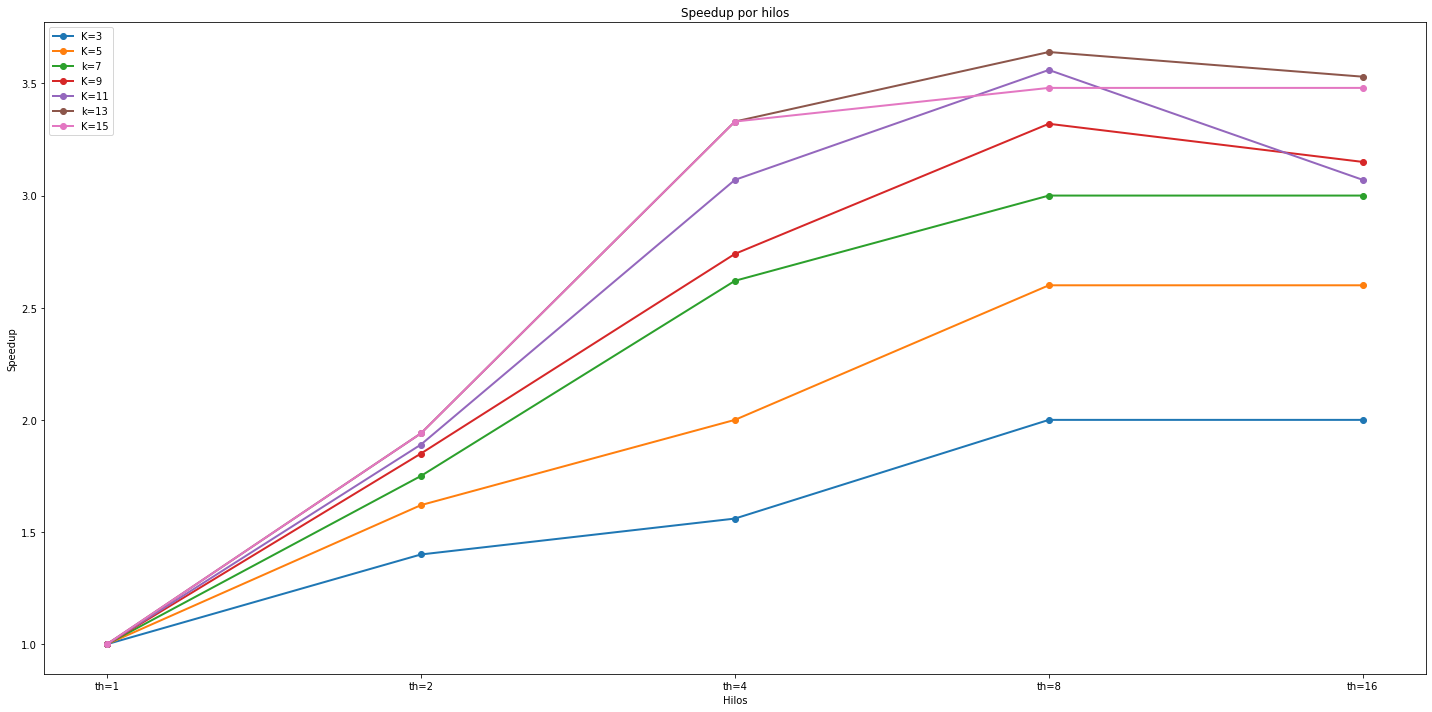

Image name: 1080


,K=3,K=5,k=7,K=9,K=11,k=13,K=15
th=1,0.31,0.59,0.92,1.38,1.95,2.62,3.40
th=2,0.18,0.31,0.50,0.73,1.01,1.35,1.75
th=4,0.15,0.22,0.31,0.44,0.58,0.76,0.97
th=8,0.12,0.18,0.27,0.39,0.54,0.71,0.91
th=16,0.12,0.19,0.28,0.40,0.55,0.73,0.94


,K=3,K=5,k=7,K=9,K=11,k=13,K=15
th=1,1.00,1.00,1.00,1.00,1.00,1.00,1.00
th=2,1.72,1.90,1.84,1.89,1.93,1.94,1.94
th=4,2.07,2.68,2.97,3.14,3.36,3.45,3.51
th=8,2.58,3.28,3.41,3.54,3.61,3.69,3.74
th=16,2.58,3.11,3.29,3.45,3.55,3.59,3.62


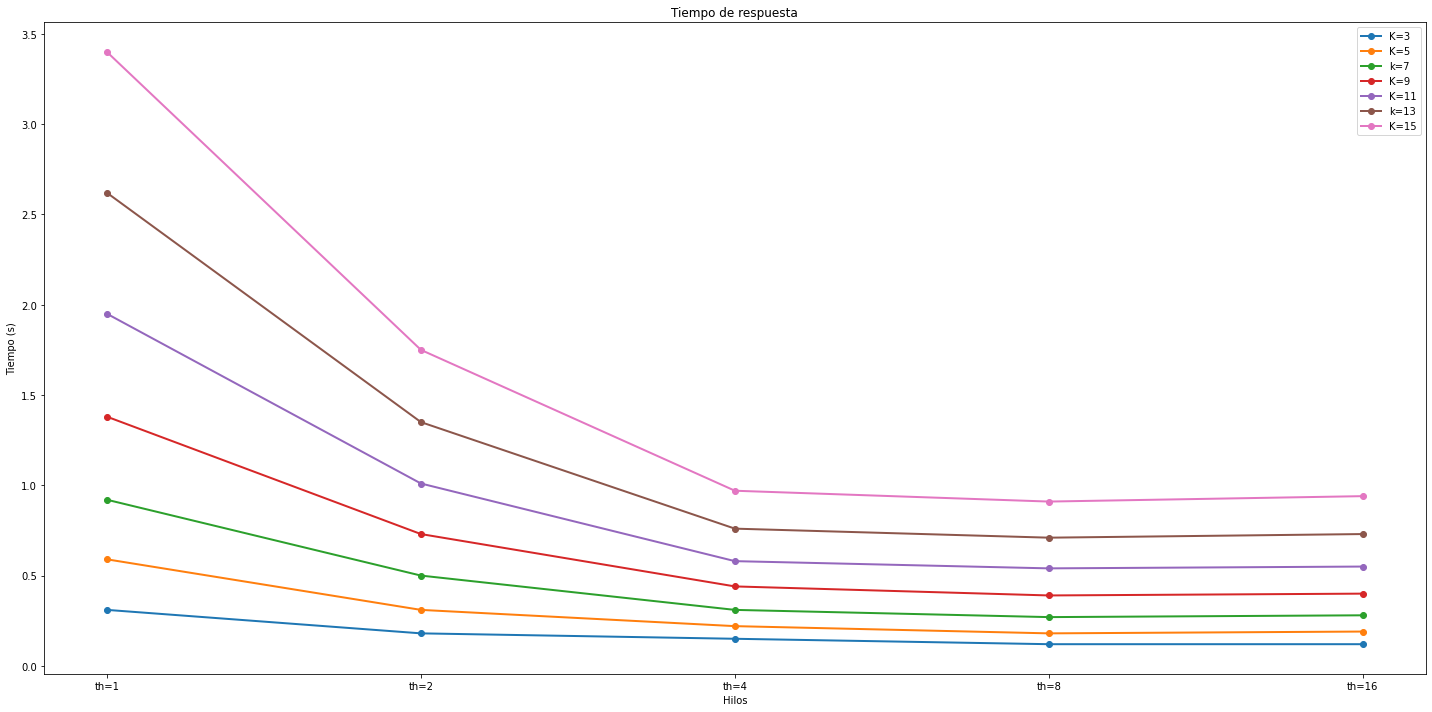

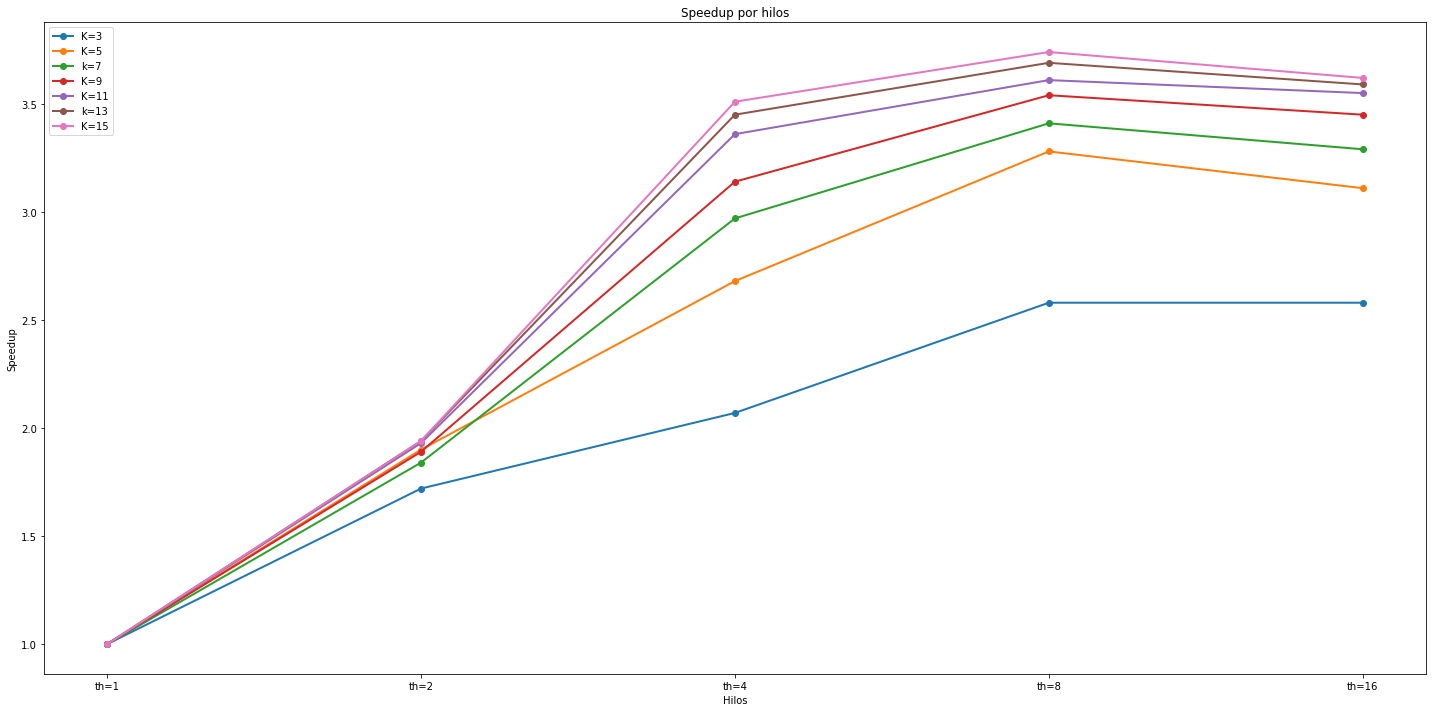

Image name: 4k


,K=3,K=5,k=7,K=9,K=11,k=13,K=15
th=1,1.17,2.25,3.67,5.55,7.80,10.49,13.57
th=2,0.73,1.27,1.99,2.91,4.05,5.40,7.21
th=4,0.53,0.82,1.19,1.68,2.27,3.01,3.80
th=8,0.48,0.74,1.10,1.57,2.16,2.86,3.74
th=16,0.50,0.77,1.13,1.61,2.20,2.89,3.70


,K=3,K=5,k=7,K=9,K=11,k=13,K=15
th=1,1.00,1.00,1.00,1.00,1.00,1.00,1.00
th=2,1.60,1.77,1.84,1.91,1.93,1.94,1.88
th=4,2.21,2.74,3.08,3.30,3.44,3.49,3.57
th=8,2.44,3.04,3.34,3.54,3.61,3.67,3.63
th=16,2.34,2.92,3.25,3.45,3.55,3.63,3.67


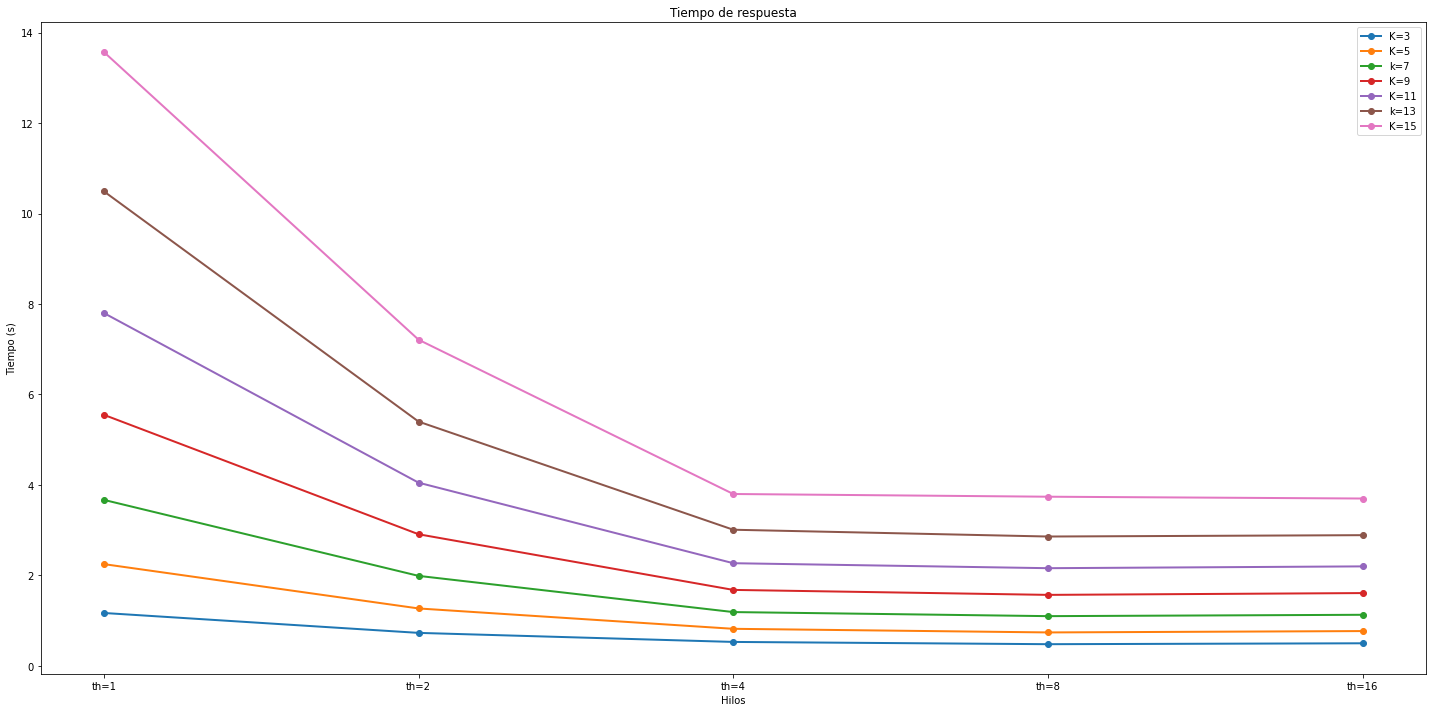

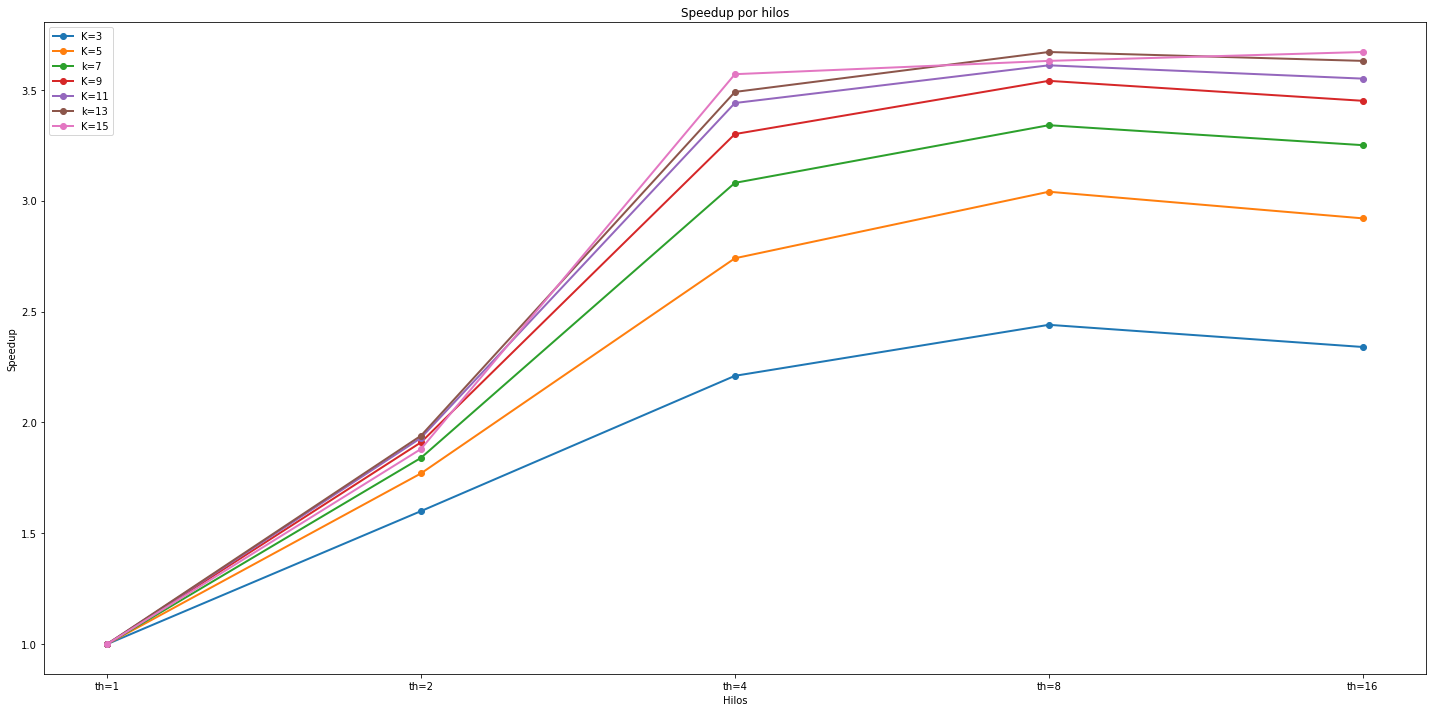

In [10]:
for image in ('720', '1080', '4k'):
    plot_results(image)